# Variational Autoencoder for anomaly detection


### Import

In [1]:
import tensorflow as tf 

import matplotlib.pyplot as plt 
import numpy as np 
 
import os 

from IPython import display 
import cv2

In [15]:
def load_images_from_folder(folder):
    images=[]
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None: 
            img = cv2.resize(img, (128,128))
            images.append(img)
    return np.array(images)

train_folder_path = "./Fabric-Data/train_data/"
test_folder_path = ""

train_data = load_images_from_folder(train_folder_path)
test_data = load_images_from_folder(test_folder_path)

# Normalize the data
train_data = train_data.astype('float32')/255.0
test_data = test_data.astype('float32')/255.0

### Display the images

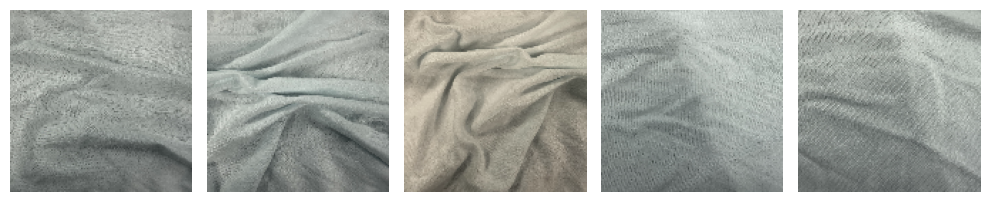

In [16]:
def display_images(images, num_images=4, figsize=(10, 5)):
    plt.figure(figsize=figsize)
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i], cmap='gray')  # Adjust the colormap based on image color format
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Assuming image_data is already loaded and preprocessed
# Display the first 5 images from image_data
display_images(train_data, num_images=5)

### Build the Model 

#### Sampling Class

This layer provide the Gaussian noise input along with the mean ($\mu $) and standard deviation ($\sigma$) of the encoder's output, according to the following equation:
**$$z = \mu + e^{0.5\sigma} * \epsilon $$**
($\epsilon$ = random sample)

In [5]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        ''' Generates a random sample and combines with the encoder output
        Args:
        inputs - output tensor from the encoder 
        Returns: 
        'inputs' tensors combined with a random sample
        '''
        mu, sigma = inputs
        batch = tf.shape(mu)[0]
        dim = tf.shape(mu)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        z = mu + tf.exp(0.5*sigma)*epsilon
        return z 
    

#### Encoder Layers


In [6]:
def encoder_layers(inputs, latent_dim):
    ''' Defines the encoder's layers.
    Args: 
        input: a batch from the dataset
        latent_dim: dimensionality of the latent space
        
    Returns:
        mu: learned mean
        sigma: learned standard deviation
        feature_shape: shape of the features before flattening
    '''

    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, 
                               padding='same', name='encode_conv1')(inputs)
    x = tf.keras.layers.LeakyReLU(0.1)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, 
                               padding='same', name='encode_conv2')(x)
    x = tf.keras.layers.LeakyReLU(0.1)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, 
                               padding='same', name='encode_conv3')(x)
    x = tf.keras.layers.LeakyReLU(0.1)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, 
                               padding='same', name='encode_conv4')(x)
    x = tf.keras.layers.LeakyReLU(0.1)(x)

    features = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Flatten(name='encoded_flatten')(features)
    x = tf.keras.layers.Dense(1024, activation='relu', name='encode_dense')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    mu = tf.keras.layers.Dense(latent_dim, name='latent_mu')(x)
    sigma = tf.keras.layers.Dense(latent_dim, name='latent_sigma')(x)
    return mu, sigma, features.shape



#### Encoder Model

In [7]:
def encoder_model(latent_dim, input_shape):
    '''Define the encoder model with the Sampling layer
    Args:
        latent_dim: dimensionality of the latent space
        input_shape: shape of a batch from the dataset
    Returns:
        model: the encoder model
        feature_shape: shape of the features before flattening
    '''
    inputs = tf.keras.layers.Input(shape=input_shape)
    mu, sigma, feature_shape = encoder_layers(inputs=inputs, latent_dim=latent_dim)
    z = Sampling()((mu, sigma))
    # Trong class Sampling ko co __init__ >> Sampling()
    # Func call co param "inputs", inputs = mu, sigma >> Sampling()((mu, sigma))
    # hay inputs = tuple cua mu & sigma
    model = tf.keras.Model(inputs=inputs, outputs=[mu, sigma, z])
    # [mu, sigma, z] are the latent representations
    model.summary()
    return model, feature_shape

#### Decoder Layers

In [8]:
def decoder_layers(inputs, feature_shape):
    ''' Define the decoder layers
    Args: 
        inputs: output of the encoder
        feature_shape: shape of the features before flattening

    Returns:
        Tensor containing the decoded output
        '''
    units = feature_shape[1] * feature_shape[2] * feature_shape[3]
    x = tf.keras.layers.Dense(units, activation='relu', name='decode_dense1')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Reshape((feature_shape[1], feature_shape[2], feature_shape[3]), name='decode_reshape')(x)
    
    # Upsample the features back to the original dimension
    x = tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=3, strides=2, padding='same', activation='relu', name='decode_conv_transpose1')(x)
    x = tf.keras.layers.BatchNormalization()(x) 
    x = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same', activation='relu', name='decode_conv_transpose2')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name='decode_conv_transpose3')(x)
    x = tf.keras.layers.BatchNormalization()(x)    
    x = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu', name='decode_conv_transpose4')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=1, padding='same', activation='sigmoid')(x)

    return x

#### Decoder Model

In [9]:
def decoder_model(latent_dim, feature_shape):
    '''Defines the decoder model.
    Args: 
        latent_dim: dimensionality of the latent space
        conv_shape: shape of the features before flattening
    Returns:
        model: the decoder model 
    '''
    inputs = tf.keras.layers.Input(shape=(latent_dim,))
    outputs = decoder_layers(inputs, feature_shape)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.summary()
    return model

#### VAE 

In [10]:
def vae_model(encoder, decoder, input_shape):
    '''
    Defines the VAE model:
    Args:
        encoder: encoder_model
        decoder: decoder_model
        input_shape: shape of the dataset_batch
    Return:
        VAE model
    '''
    inputs = tf.keras.layers.Input(shape=input_shape)

    mu, sigma, z = encoder(inputs)
    reconstructed = decoder(z)

    model = tf.keras.Model(inputs=inputs, outputs=reconstructed)
    return model 

In [11]:
def get_models(input_shape, latent_dim):
    encoder, feature_shape = encoder_model(latent_dim, input_shape)
    decoder = decoder_model(latent_dim, feature_shape)
    vae = vae_model(encoder, decoder, input_shape)

    return encoder, decoder, vae 


In [12]:
encoder, decoder, vae = get_models(input_shape=(128,128,3,), latent_dim=128)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_conv1 (Conv2D)          (None, 64, 64, 32)   896         ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64, 64, 32)   0           ['encode_conv1[0][0]']           
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 32)  128         ['leaky_re_lu[0][0]']        

#### Train the model

#### Training

In [13]:

vae.compile(optimizer='adam', metrics=['accuracy'], loss="mse")

In [17]:
vae.fit(train_data, train_data, epochs=200, batch_size=2, shuffle=True)

Epoch 1/200


ValueError: Creating variables on a non-first call to a function decorated with tf.function.